In [1]:
import os
import time

import mido
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def getData(data_folder):
    """
    Walk through a folder, modifing each mid to fit in 128 ticks per beat and be only a piano channel
    :param data_folder: the base data folder used in the model, still nonrepresentative
    :return: it saves a midfile in piano format and other in paino+128tpb
    """
    counter = 0
    for dirpath, _, filenames in os.walk(data_folder):
        for File in filenames:
            path = os.path.join(dirpath, File)
            mid_copy = mido.MidiFile()

            try:
                mid = mido.MidiFile(path)
                tpb = mid.ticks_per_beat
                duration = int(mid.length)

                mid_copy.type = 1
                mid_copy.ticks_per_beat = tpb

                if 10 < duration < 600:
                    track = mido.merge_tracks(mid.tracks)

                    for msg in list(track):
                        if not msg.is_meta and msg.channel != 0 and msg.type == "note_on":
                            msg.velocity = 0

                mid_copy.tracks.append(track)
                mid_copy.save(f"OnlyPiano/{File}")

                mid_copy.ticks_per_beat = 128
                mid_copy.save(f"OnlyPiano_TPB128/{File}")

            except:
                print(path)
                continue

            counter += 1
            if counter % 250 == 0:
                print(counter)

In [3]:
start_time = time.time()
getData('TestDataset')
print("--- %s seconds ---" % (time.time() - start_time))

TestDataset\DG_SMB_Main.mid
TestDataset\gbc_smbd_sm01.mid
TestDataset\SMB-select-game-menu.mid
TestDataset\SMB1OVR.mid
TestDataset\smb2overworld1.mid
TestDataset\SMB3-Airship-of-doom.mid
TestDataset\SMB3ATHL.mid
TestDataset\SMB3_-_IceDnBMSGS.mid
TestDataset\SMB_Star-KM.mid
TestDataset\SonicA3_-_7Boss.mid
TestDataset\SonicAdv3_-_ChaosAngelDiscoPop.mid
TestDataset\SonicAdv3_-_SunsetHillZoneRemixXG.mid
TestDataset\SonicAdvance2_-_EXZone53.mid
TestDataset\SonicAdvance3_-_EXBOSS.mid
TestDataset\SonicAdvance3_-_TwinkleSnowArrangeXG.mid
TestDataset\SonicA_-_Xboss3.mid
TestDataset\SonicBattle_-_CentralCity.mid
TestDataset\SonicB_-_CreditsXG.mid
TestDataset\SonicRi_-_DigiDimension-J.mid
TestDataset\Sonic_GBA_Angel1_TBCancumFX_V1_2.mid
TestDataset\Sonic_GBA_Angel1_XG_V1_2.mid
TestDataset\Sonic_Heroes_Hang_CastleXG.mid
TestDataset\Sonic_Riders_-_Babylon_Garden.mid
TestDataset\Sonic_Riders_-_Start_Up_Your_Ex_Gear.mid
TestDataset\S_T_s_theme_sonic_melee_5.mid
--- 166.7405300140381 seconds ---


In [4]:
def get_info(data_folder):
    counter = 0
    for dirpath, _, filenames in os.walk(data_folder):
        for File in filenames:
            path = os.path.join(dirpath, File)

            try:
                mid = mido.MidiFile(path)
                duration = mid.length
                track = mido.merge_tracks(mid.tracks)
                delta_time_ticks = 0

                for msg in list(track):
                    delta_time_ticks += msg.time


#                     if not msg.is_meta and msg.channel ==0:
#                         print(msg)
                beat_num = int(delta_time_ticks / 128)
                num_compasso = int(beat_num / 4)
                print(duration)
                print(delta_time_ticks)
                print(beat_num)
                print(num_compasso)
                print(int(num_compasso - 3))

            except:
                print(path)
                continue

            return mid

In [5]:
mid = get_info('TestDataset')

52.36074309375032
18431
143
35
32


In [9]:
TICKS_PER_BEAT = 64
BEAT_PER_COMPASS = 4
NUM_COMPASS = 4

def midi_to_pianoroll(mid):
    NUM_TICKS = TICKS_PER_BEAT * BEAT_PER_COMPASS * NUM_COMPASS

    track_num_ticks = mid.ticks_per_beat * BEAT_PER_COMPASS * NUM_COMPASS

    pianoroll = np.zeros((128, NUM_TICKS), dtype=np.uint8)
    state = np.zeros((128, 1), dtype=np.uint8)
    last_tick = 0
    current_tick = 0

    merged_track = mido.merge_tracks(mid.tracks)
    for msg in merged_track:
        new_tick = current_tick + msg.time
        if new_tick >= track_num_ticks:
            break
        current_tick = new_tick
        
        if msg.type not in ['note_on', 'note_off']:
            continue

        if current_tick != last_tick:
            pianoroll_last_tick = int(last_tick * TICKS_PER_BEAT /
                                      mid.ticks_per_beat)

            pianoroll_current_tick = int(current_tick * TICKS_PER_BEAT /
                                         mid.ticks_per_beat)

            pianoroll[:, pianoroll_last_tick:pianoroll_current_tick] = state

        last_tick = current_tick

        if msg.type == 'note_on' and msg.velocity > 0:
            state[msg.note] = msg.velocity
        elif msg.type == 'note_off':
            state[msg.note] = 0

    if current_tick < track_num_ticks:
        pianoroll_last_tick = int(last_tick * TICKS_PER_BEAT /
                                  mid.ticks_per_beat)
        pianoroll[:, pianoroll_last_tick:] = state

    return pianoroll


def pianoroll_to_midi(pianoroll):
    track = mido.MidiTrack()

    last_state = np.zeros(128, dtype=np.uint8)
    last_tick = 0
    for tick in range(0, pianoroll.shape[1]):
        current_state = pianoroll[:, tick]
        note_mismatches = current_state != last_state
        if not note_mismatches.any():
            continue
        changing_pos = np.where(note_mismatches)
        event_time = tick - last_tick
        last_tick = tick
        for note in changing_pos[0]:
            current_velocity = current_state[note]
            msg_type = 'note_off' if current_velocity == 0 else 'note_on'
            track.append(
                mido.Message(
                    msg_type,
                    note=note,
                    velocity=current_velocity,
                    time=16*event_time,
                ))

        last_state = current_state

    mid = mido.MidiFile()
    mid.tracks.append(track)
    return mid


pianoroll = midi_to_pianoroll(mid)
new_mid = pianoroll_to_midi(pianoroll)

new_mid.save('teste.mid')

In [7]:
np.shape(pianoroll)

(128, 512)

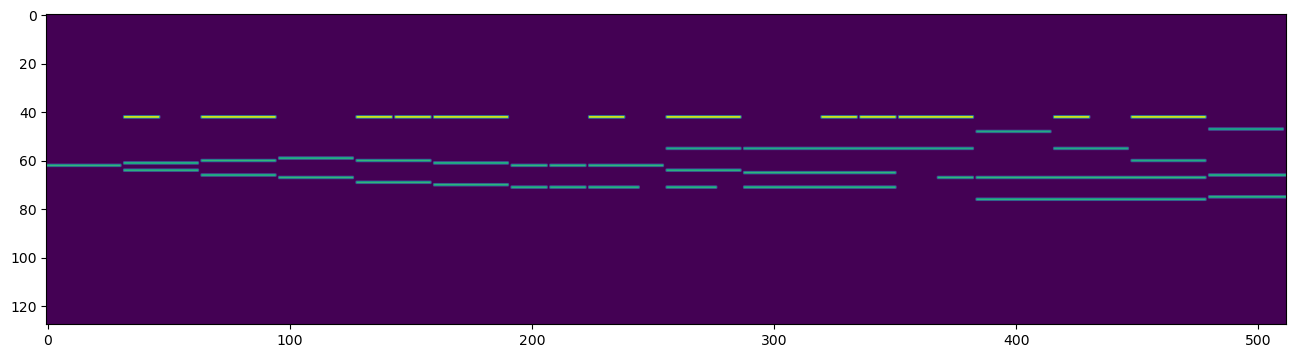

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 64))
plt.imshow(pianoroll)
plt.show()